In [1]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastbook import *
from IPython.display import display,HTML

# Downloading the dataset

In [3]:
from fastai.text.all import *
path = untar_data(URLs.AMAZON_REVIEWS_POLARITY)

In [4]:
train = pd.read_csv(path/'train.csv')
test = pd.read_csv(path/'test.csv')

In [5]:
len(train)

3599999

In [6]:
train.shape

(3599999, 3)

In [7]:
train.columns = ['label', 'review_title', 'text']
test.columns = ['label', 'review_title', 'text']
train.head()

,label,review_title,text
0,2,The best soundtrack ever to anything.,"I'm reading a lot of reviews saying that this is the best 'game soundtrack' and I figured that I'd write a review to disagree a bit. This in my opinino is Yasunori Mitsuda's ultimate masterpiece. The music is timeless and I'm been listening to it for years now and its beauty simply refuses to fade.The price tag on this is pretty staggering I must say, but if you are going to buy any cd for this much money, this is the only one that I feel would be worth every penny."
1,2,Amazing!,"This soundtrack is my favorite music of all time, hands down. The intense sadness of ""Prisoners of Fate"" (which means all the more if you've played the game) and the hope in ""A Distant Promise"" and ""Girl who Stole the Star"" have been an important inspiration to me personally throughout my teen years. The higher energy tracks like ""Chrono Cross ~ Time's Scar~"", ""Time of the Dreamwatch"", and ""Chronomantique"" (indefinably remeniscent of Chrono Trigger) are all absolutely superb as well.This soundtrack is amazing music, probably the best of this composer's work (I haven't heard the Xenogears s..."
2,2,Excellent Soundtrack,"I truly like this soundtrack and I enjoy video game music. I have played this game and most of the music on here I enjoy and it's truly relaxing and peaceful.On disk one. my favorites are Scars Of Time, Between Life and Death, Forest Of Illusion, Fortress of Ancient Dragons, Lost Fragment, and Drowned Valley.Disk Two: The Draggons, Galdorb - Home, Chronomantique, Prisoners of Fate, Gale, and my girlfriend likes ZelbessDisk Three: The best of the three. Garden Of God, Chronopolis, Fates, Jellyfish sea, Burning Orphange, Dragon's Prayer, Tower Of Stars, Dragon God, and Radical Dreamers - Uns..."
3,2,"Remember, Pull Your Jaw Off The Floor After Hearing it","If you've played the game, you know how divine the music is! Every single song tells a story of the game, it's that good! The greatest songs are without a doubt, Chrono Cross: Time's Scar, Magical Dreamers: The Wind, The Stars, and the Sea and Radical Dreamers: Unstolen Jewel. (Translation varies) This music is perfect if you ask me, the best it can be. Yasunori Mitsuda just poured his heart on and wrote it down on paper."
4,2,an absolute masterpiece,"I am quite sure any of you actually taking the time to read this have played the game at least once, and heard at least a few of the tracks here. And whether you were aware of it or not, Mitsuda's music contributed greatly to the mood of every single minute of the whole game.Composed of 3 CDs and quite a few songs (I haven't an exact count), all of which are heart-rendering and impressively remarkable, this soundtrack is one I assure you you will not forget. It has everything for every listener -- from fast-paced and energetic (Dancing the Tokage or Termina Home), to slower and more haunti..."


# Training a Text Classifier

In [8]:
dls_lm = TextDataLoaders.from_df(train[:100000], path=path, text_col='text', is_lm=True)
dls_lm.show_batch(max_n=3)

/home/orjan/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


,text,text_
0,"xxbos xxmaj i 'm sitting here chuckling as i write this . xxmaj when they came out with the xxmaj mach 3 , i thought to myself "" how ridiculous ! xxmaj who needs three blades ? "" . xxmaj when the xxmaj fusion came out , i was openly hostile - "" how many xxrep 5 * blades do we need ? xxmaj stop the madness ! ! "" . xxmaj","xxmaj i 'm sitting here chuckling as i write this . xxmaj when they came out with the xxmaj mach 3 , i thought to myself "" how ridiculous ! xxmaj who needs three blades ? "" . xxmaj when the xxmaj fusion came out , i was openly hostile - "" how many xxrep 5 * blades do we need ? xxmaj stop the madness ! ! "" . xxmaj well"
1,"off xxmaj the xxmaj shining , xxmaj the xxmaj ring , xxmaj the xxmaj blair xxmaj witch xxmaj project , xxmaj hellraiser . . . oh , yeah , and xxmaj the xxmaj amityville xxmaj horror . i now understand why xxmaj i 've always avoided seeing his movies . xxbos xxmaj this is a great overview of "" the xxmaj troubles "" in xxmaj northern xxmaj ireland , the background to","xxmaj the xxmaj shining , xxmaj the xxmaj ring , xxmaj the xxmaj blair xxmaj witch xxmaj project , xxmaj hellraiser . . . oh , yeah , and xxmaj the xxmaj amityville xxmaj horror . i now understand why xxmaj i 've always avoided seeing his movies . xxbos xxmaj this is a great overview of "" the xxmaj troubles "" in xxmaj northern xxmaj ireland , the background to the"
2,"drop dead "" money . xxmaj like , we got the point . xxbos i live in a fairly small city , so we only have the basic big brand grocery stores here . xxmaj some of the things in these recipes are expensive and difficult to find . xxmaj also , the recipes are pretty time consuming . xxmaj the food is xxunk though , so if you do n't spending","dead "" money . xxmaj like , we got the point . xxbos i live in a fairly small city , so we only have the basic big brand grocery stores here . xxmaj some of the things in these recipes are expensive and difficult to find . xxmaj also , the recipes are pretty time consuming . xxmaj the food is xxunk though , so if you do n't spending a"


In [9]:
learn_lm = language_model_learner(
    dls_lm, AWD_LSTM, drop_mult=0.3, 
    metrics=[accuracy, Perplexity()]).to_fp16()

SuggestedLRs(lr_min=0.010964781790971757, lr_steep=0.019054606556892395)

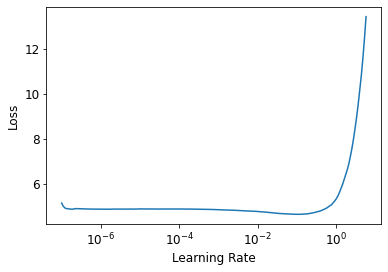

In [10]:
learn_lm.lr_find(stop_div=False, num_it=200)

In [11]:
learn_lm.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,4.021819,3.908096,0.289705,49.804016,04:01


In [12]:
learn_lm.save('1epoch')

Path('/home/orjan/.fastai/data/amazon_review_polarity_csv/models/1epoch.pth')

In [13]:
learn_lm = learn_lm.load('1epoch')

SuggestedLRs(lr_min=1.0964781722577754e-06, lr_steep=6.918309622960805e-07)

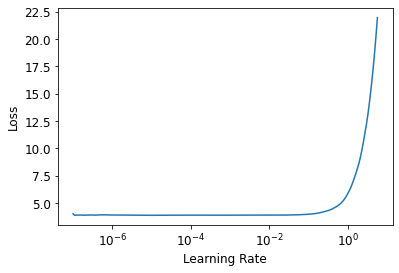

In [14]:
learn_lm.lr_find(stop_div=False, num_it=200)

In [15]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(1,1e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.772708,3.751701,0.311711,42.593468,04:20


In [16]:
learn_lm.save('2epoch')

Path('/home/orjan/.fastai/data/amazon_review_polarity_csv/models/2epoch.pth')

In [17]:
learn_lm = learn_lm.load('2epoch')

SuggestedLRs(lr_min=2.2908675418875645e-07, lr_steep=6.918309622960805e-07)

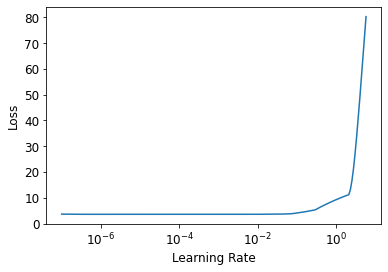

In [18]:
learn_lm.lr_find(stop_div=False, num_it=200)

In [19]:
learn_lm.unfreeze()
learn_lm.fit_one_cycle(1,1e-2)

epoch,train_loss,valid_loss,accuracy,perplexity,time
0,3.719010,3.737643,0.313791,41.998894,04:23


In [20]:
learn_lm.save_encoder('finetuned')

# Making a review

In [10]:
learn_lm = learn_lm.load_encoder('finetuned')

In [11]:
TEXT = "I liked this movie because"
N_WORDS = 40
N_SENTENCES = 1
preds = [learn_lm.predict(TEXT, N_WORDS, temperature=0.75) 
         for _ in range(N_SENTENCES)]

In [12]:
print("\n".join(preds))

i liked this movie because the characters and plot were so well written as to be hilarious , but the ending was overdone and half - baked . While the book itself has a lot of info that were previously available , the


In [13]:
TEXT = "Amazing book"
N_WORDS = 40
N_SENTENCES = 1
preds = [learn_lm.predict(TEXT, N_WORDS, temperature=0.75) 
         for _ in range(N_SENTENCES)]
print("\n".join(preds))

Amazing book for anyone who has ever read Twain who was in his early forties . They were not a band in this generation , that they were never to present themselves without their heart . This is a


# Creating a classifier

In [9]:
dls_clas = DataBlock(
    blocks=(TextBlock.from_df('text', vocab=dls_lm.vocab),CategoryBlock),
    get_x=ColReader('text'), get_y=ColReader('label'), 
    splitter=RandomSplitter(0.1)
).dataloaders(test[:100000])

/home/orjan/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [11]:
torch.cuda.empty_cache()

In [29]:
dls_clas.show_batch(max_n=2)

,text,category
0,"xxbos i xxup got xxup this "" album "" xxup for xxup my xxup thirteenth xxup birthday , xxup in xxunk xxup remember xxup the xxup album xxup came xxup with a xxup poster xxup and i xxup had xxup it xxup hanging xxup up xxup in xxup my xxup room xxup for xxup years ) . i xxup have xxup been xxup listening xxup to xxup it xxup ever xxup since , i xxup will xxup never , xxup ever xxup get xxup tired xxup of xxup hearing xxup this xxup one . xxup it xxup may xxup well xxup be xxup the xxup greatest ( and xxup certainly xxup one xxup of xxup the xxup first ) "" live "" xxup rock xxup and xxup roll xxup albums xxup of xxup all xxup time . xxup you xxup need xxup to xxup turn xxup the xxup volume xxup",2
1,xxbos i xxup guess xxup if xxup you xxup are a xxup film xxup student / xxup fan xxup of xxup adam xxup west / xxup hot xxup for xxup tobey xxup maguire / xxup amy xxup hathaway / xxup have xxup seen xxup every xxup other xxup movie xxup out xxup there / xxup etc / xxup etc / xxup etc … then xxup just xxup maybe xxup you xxup could xxup give xxup this xxup movie xxup any xxup more xxup than 3 xxup stars . i xxup do n't xxup think xxup the xxup movie xxup was xxup bad - xxup there xxup was 20 xxup min xxup or xxup so xxup of xxup mildly xxup entertaining xxup clips xxup altogether - xxup but xxup the xxup way xxup some xxup of xxup you ( reviewers ) xxup make xxup some xxup of xxup these xxup mediocre,1


In [10]:
learn = text_classifier_learner(dls_clas, AWD_LSTM, drop_mult=0.5, 
                                metrics=accuracy).to_fp16()

In [9]:
learn = learn.load_encoder('finetuned')

SuggestedLRs(lr_min=0.5754399299621582, lr_steep=5.248074531555176)

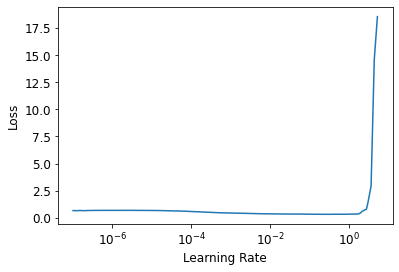

In [10]:
learn.lr_find(stop_div=False, num_it=200)

In [11]:
learn.fit_one_cycle(1, 1e-1)

epoch,train_loss,valid_loss,accuracy,time
0,0.237340,0.225976,0.910200,00:39


In [12]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(1e-2/(2.6**4),1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.234575,0.220938,0.912400,00:47


In [13]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.237058,0.219083,0.912700,01:06


In [14]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.236057,0.217612,0.913600,01:32
1,0.228005,0.217396,0.913100,01:33


In [15]:
learn.save('Classification')

Path('models/Classification.pth')

In [11]:
learn = learn.load('Classification')

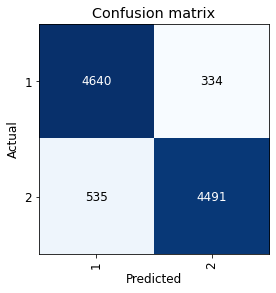

In [14]:
interp.plot_confusion_matrix()

In [12]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(5, nrows=1)

,input,target,predicted,probability,loss
0,xxbos who ever alblum was lame ur lame to that dude said this worst album 2 u eat a fat xxunk,2,1,0.9997867941856384,8.453338623046875
1,xxbos xxmaj the shooting mechanism of the guns broke after 10 uses . xxmaj durability is extremely poor xxrep 3 !,2,1,0.998542070388794,6.530755996704102
2,"xxbos xxmaj as another reviewer stated , this company has moronic shipping practices . i ordered five rolls , and received , via 2-day air , 5 big boxes , any one of which could have held about 10 rolls . xxmaj i 'm an xxmaj amazon xxmaj prime member , so it did n't cost me anything , but it 's a ridiculous waste of resources . xxmaj are these people nuts , or just incompetent ?",2,1,0.9978129863739014,6.1252360343933105
3,xxbos xxmaj this was the best book i have ever read . i like how the spies where those special xxmaj uniforms . the characters did many exiting stuff . i gave this book 1 star because it taught children bad stuff . xxmaj this is the most wonderful book i have ever read . cheap too ! i would recomend it for you .,1,2,0.9974589943885803,5.975200653076172
4,xxbos xxmaj it holds your attention . i have been very busy and i have not been able to complete the book as yet . xxmaj but i have enjoyed it so far .,1,2,0.9968580007553101,5.762912750244141
